In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

In [2]:
# Functions

def symbol_to_path(symbol, base_dir = 'data'):
    '''Return CSV file path given ticker symbol'''
    return os.path.join(base_dir, '{}.csv'.format(str(symbol)))

def get_data(symbols, dates):
    '''Read stock data (adjusted close) given symbols, from CSV files'''
    df = pd.DataFrame(index = dates)
    if 'SPY' not in symbols:  # Add SPY for reference, if absent
        symbols.insert(0,'SPY')
    for symbol in symbols:
        df_temp = pd.read_csv(symbol_to_path(symbol), 
                          index_col = 'Date', 
                          parse_dates = True, 
                          usecols = ['Date', 'Adj Close'], 
                          na_values = ['nan'])
        df_temp = df_temp.rename(columns = {'Adj Close': symbol})
        df = df.join(df_temp)
        if symbol == 'SPY': # drop dates SPY did not trade
            df = df.dropna(subset=['SPY'])
    return df

def plot_data(df, title = 'Stock prices', ylabel = 'Price'):
    '''Plot stock prices'''
    ax = df.plot(title = title, fontsize = 12)
    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel)
    plt.show()
    
def get_bollinger_bands(rm, rstd):
    '''Return upper and lower Bollinger bands'''
    upper_band = rm + 2 * rstd
    lower_band = rm - 2 * rstd
    return upper_band, lower_band

def get_rolling_mean(df, window):
    return pd.rolling_mean(df, window = window)

def get_rolling_std(df, window):
    return pd.rolling_std(df, window = window)

def compute_daily_returns(df):
    '''Compute and return daily return values using pandas'''
    daily_returns = (df / df.shift(1)) - 1 # pandas shifts *back*
    daily_returns.ix[0,:] = 0 # pandas puts NaNs in row 0
    return daily_returns

def compute_cumulative_returns(df):
    '''Compute and return cumulative return values'''
    cum_returns = df.copy() # copy dataframe to match size, rows and columns
    cum_returns = (df/df.ix[0,:].values) - 1
    return cum_returns

### Kurtosis

- Measure of how different the tails of the distribution are from a gaussian.
- If kurtosis is postive = fat tails; negative = skinny tails.
- Kurtosis can be used to measure non-gaussianity. 
- Kurtosis measures the degree of peakedness (spikiness) of a distribution and it is zero only for Gaussian distribution. Any other distribution's kurtosis is either positive if it is supergaussian (spikier than Gaussian) or negative if it is subgaussian (flatter than Gaussian). Therefore the absolute value of the kurtosis or kurtosis squared can be used to measure the non-Gaussianity of a distribution. 
- However, kurtosis is very sensitive to outliers, and it is not a robust measurement of non-Gaussianity.
- scipy <a href=""https://docs.scipy.org/doc/scipy-0.7.x/reference/generated/scipy.stats.kurtosis.html>kurtosis</a> and pandas <a href-"http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.kurtosis.html">kurtosis</a>
- <a href="http://stackoverflow.com/questions/33109107/what-is-the-difference-between-skew-and-kurtosis-functions-in-pandas-vs-scipy">Difference</a> between scipy and pandas kurtosis (and skewness) - The difference is due to different normalizations. Scipy by default does not correct for bias, whereas pandas does. You can tell scipy to correct for bias by passing the bias=False argument. There does not appear to be a way to tell pandas to remove the bias correction.
- Skewness - A measure of the asymmetry of a distribution. The normal distribution is symmetric, and has a skewness value of zero. A distribution with a significant positive skewness has a long right tail. A distribution with a significant negative skewness has a long left tail. As a rough guide, a skewness value more than twice it's standard error is taken to indicate a departure from symmetry.
- In practical terms, skewness is probably more important than kurtosis, and positive skew is probably more common than negative skew. Most variables with a fixed lower limit but no fixed upper limit (for example, income -- assuming income can't be less than 0) will tend to be positively skewed.

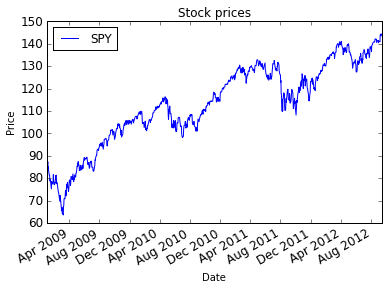

In [3]:

dates = pd.date_range('2009-01-01', '2012-12-31')

symbols = ['SPY']

df = get_data(symbols, dates)
plot_data(df)


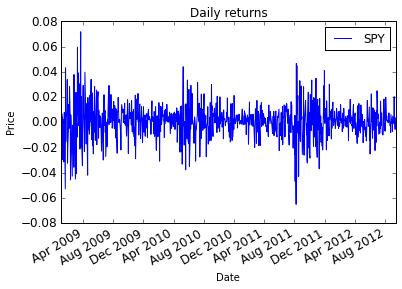

In [4]:
daily_returns = compute_daily_returns(df)
plot_data(daily_returns, title = 'Daily returns')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x105d75e10>]], dtype=object)

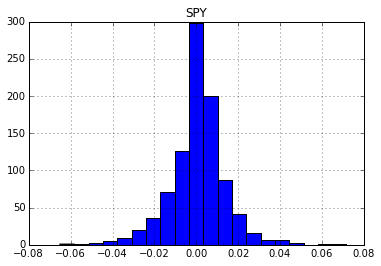

In [5]:
daily_returns.hist(bins = 20)

mean= 0.000635578332225
std= 0.0133704908994


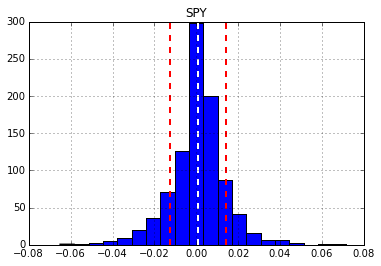

In [6]:
# Get mean and standard deviation

mean = daily_returns['SPY'].mean()
print 'mean=', mean
std = daily_returns['SPY'].std()
print 'std=', std
daily_returns.hist(bins = 20)
plt.axvline(mean, color = 'w', linestyle = 'dashed', linewidth = 2)
plt.axvline(mean + std, color = 'r', linestyle = 'dashed', linewidth = 2)
plt.axvline(mean - std, color = 'r', linestyle = 'dashed', linewidth = 2)


In [7]:
# computer kurtosis

print daily_returns.kurtosis()

SPY    3.220278
dtype: float64


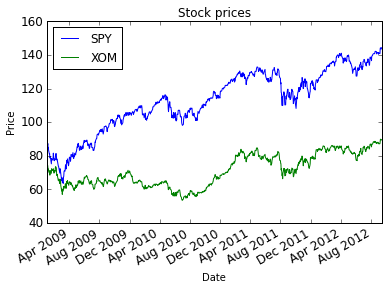

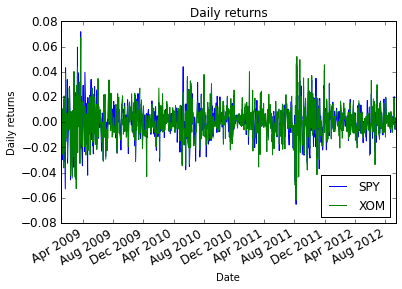

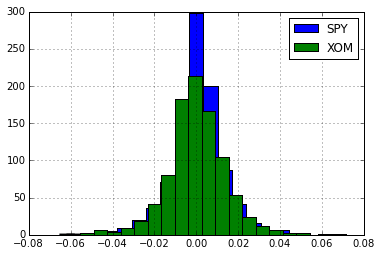

In [8]:
# plot 2 histograms

dates = pd.date_range('2009-01-01', '2012-12-31')
symbols = ['SPY', 'XOM']

df = get_data(symbols, dates)
plot_data(df)

# compute daily returns

daily_returns = compute_daily_returns(df)
plot_data(daily_returns, title = 'Daily returns', ylabel = 'Daily returns')
daily_returns['SPY'].hist(bins = 20, label = 'SPY')
daily_returns['XOM'].hist(bins = 20, label = 'XOM')
plt.legend(loc = 'upper right')

### Alpha & Beta:
- Slope of the line is Beta. If Beta is one (slope =1), then the stock moves in the same direction as the market (SPY) or any other comparitive stock. If Beta is two, then stock moves twice as that of the market and if beta is negative then stock moves in the opposite direction of the market. 
- The vertical line that intercepts the slope is called Alpha. Postive alpha is means stock is performing better than market (SPY) or any other comparitive stock and negative alpha means stock is performing worse than the market (SPY) or any other comparitive stock. 
- An alpha of zero means the investment has exactly earned a return adequate for the volatility assumed. An alpha over zero means the investment has earned a return that has more than compensated for the volatility risk taken. An alpha of less than zero means the investment has earned a return that has not compensated for the volatility risk assumed.
- A beta of 1.0 implies a positive correlation (correlation measures direction, not volatility) where the asset moves in the same direction and the same percentage as the benchmark. A beta of -1 implies a negative correlation where the asset moves in the opposite direction but equal in volatility to the benchmark.
- A beta of zero implies no correlation between the assets. Any beta above zero would imply a positive correlation with volatility expressed by how much over zero the number is. Any beta below zero would imply a negative correlation with volatility expressed by how much under zero the number is. For example a beta of 2.0 or -2.0 would imply volatility twice the benchmark. A beta of 0.5 or -0.5 implies volatility one-half the benchmark. I use the word “implies” because beta is based on historical data and we all know historical data does not guarantee future returns.

### Difference between Correlation and Slope
- Slope of one is not equal to correaltion.
- Correlation is how tightly the individual points fit the line.
- There can be shallow slope but points tightly fitted to the line hence highly correlated or there could be a steeper slope but points not tightly fitted to the ilne.
- Correlation = 0 means data is not correlated and Correlation = 1 means data is higly correlated.

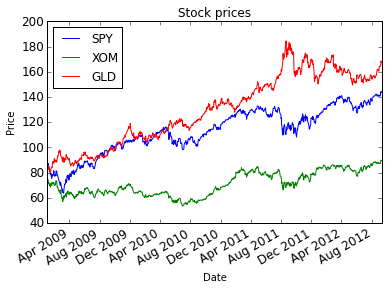

XOM beta: 0.850746223673
XOM alpha: -0.00024686727668
GLD beta: 0.0597611348322
GLD alpha: 0.00074788111616
          SPY       XOM       GLD
SPY  1.000000  0.820241  0.067324
XOM  0.820241  1.000000  0.069687
GLD  0.067324  0.069687  1.000000


/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


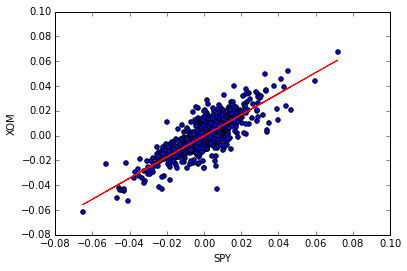

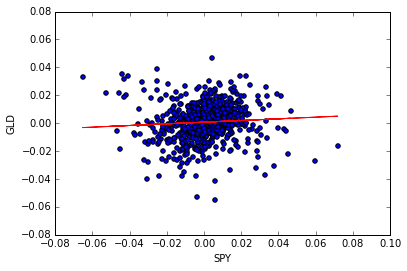

In [9]:
# Scatter plots

dates = pd.date_range('2009-01-01', '2012-12-31')
symbols = ['SPY', 'XOM', 'GLD']

df = get_data(symbols, dates)
plot_data(df)

daily_returns = compute_daily_returns(df)
daily_returns.plot(kind = 'scatter', x = 'SPY', y = 'XOM')
beta_XOM, alpha_XOM = np.polyfit(daily_returns['SPY'], 
                                 daily_returns['XOM'],1)
print 'XOM beta:', beta_XOM
print 'XOM alpha:', alpha_XOM
plt.plot(daily_returns['SPY'], beta_XOM * daily_returns['SPY'] 
         + alpha_XOM, '-', color = 'r')

daily_returns.plot(kind = 'scatter', x = 'SPY', y = 'GLD')
beta_GLD, alpha_GLD = np.polyfit(daily_returns['SPY'], 
                                 daily_returns['GLD'],1)
print 'GLD beta:', beta_GLD
print 'GLD alpha:', alpha_GLD
plt.plot(daily_returns['SPY'], beta_GLD * daily_returns['SPY'] 
         + alpha_GLD, '-', color = 'r')

print daily_returns.corr(method = 'pearson')